# Bidirectional-LSTM based RNNs for text-to-speech synthesis (en)

Source code: https://github.com/r9y9/nnmnkwii_gallery

In this notebook, we will investigate bidirectional-LSTM based Recurrent Neural Networks (RNNs). You will learn how to iterate dataset in sequence-wise (i.e., utterance-wise) manner instead of frame-wise. Dataset preparation parts are almost same as the DNN text-to-speech synthesis notebook. If you have already read the DNN text-to-speech synthesis notebook, you can skip Data section.

Generated audio examples are attached at the bottom of the notebook. For simplicity, feature extraction steps will be performed with an external python script (200 lines). To run the notebook, in addition to nnmnkwii and its dependencies, you will need the following packages:

- pytorch: http://pytorch.org/
- pysptk: https://github.com/r9y9/pysptk
- pyworld: https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder
- librosa: https://github.com/librosa/librosa
- tqdm: https://github.com/tqdm/tqdm
- docopt: https://github.com/docopt/docopt

Please make sure that you have all dependneices if you are trying to run the notebook locally.

```
pip install pysptk pyworld librosa tqdm docopt
```

Part of code is adapted from [Merlin](https://github.com/CSTR-Edinburgh/merlin). Speech analysis/synthesis is done by pysptk and pyworld. Librosa is used to visualize features. PyTorch is used to build DNN models.

The notebook requires wav files with aligned HTS-style full-context lablel files. You can download the necessary files by the following script.

In [1]:
#! ./scripts/download_data.sh slt_arctic_full_data # no-op if have already downloaded

In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import FileDataSource, FileSourceDataset
from nnmnkwii.datasets import PaddedFileSourceDataset, MemoryCacheDataset
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.preprocessing import minmax, meanvar, minmax_scale, scale
from nnmnkwii import paramgen
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join, expanduser, basename, splitext, basename, exists
import os
from glob import glob
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


## Data

In this demo we construct datasets from pre-computed linguistic/duration/acoustic features because computing features from wav/label files on-demand are peformance heavy, particulary for acoustic features. See the following python script if you are interested in how we extract features.

In [3]:
DATA_ROOT = "E:\\tts\\nnmnkwii_gallery\\data\\slt_arctic_full_data"
test_size = 0.112
random_state = 1234

In [4]:
#! python ./scripts/prepare_features.py ./data/slt_arctic_full_data

### Data specification

Almost same as Merlin's slt_arctic demo. The only difference is that frequency warping paramter `alpha` is set to 0.41, instead of 0.58. As far as I know 0.41 is the best parameter approximating mel-frequency axis for 16kHz-sampled audio signals.

In [5]:
mgc_dim = 180
lf0_dim = 3
vuv_dim = 1
bap_dim = 3

duration_linguistic_dim = 416
acoustic_linguisic_dim = 425
duration_dim = 5
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim

fs = 16000
frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

mgc_start_idx = 0
lf0_start_idx = 180
vuv_start_idx = 183
bap_start_idx = 184

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

### File data sources

We need to specify 1) where to find pre-computed features and 2) how to process them. In this case,

1. `collect_files` : Collects `.bin` files. External python script writes files in binary format. Also we split the files into train/test set.
2. `collect_features` : Just load from file by `np.fromfile`.

In [6]:
class BinaryFileSource(FileDataSource):
    def __init__(self, data_root, dim, train):
        self.data_root = data_root
        self.dim = dim
        self.train = train
    def collect_files(self):
        files = sorted(glob(join(self.data_root, "*.bin")))
        files = files[:len(files)-5] # last 5 is real testset
        train_files, test_files = train_test_split(files, test_size=test_size,
                                                   random_state=random_state)
        if self.train:
            return train_files
        else:
            return test_files
    def collect_features(self, path):
        return np.fromfile(path, dtype=np.float32).reshape(-1, self.dim)

In [7]:
X = {"duration":{}, "acoustic": {}}
Y = {"duration":{}, "acoustic": {}}
utt_lengths = {"duration":{}, "acoustic": {}}
for ty in ["duration", "acoustic"]:
    for phase in ["train", "test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguisic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        X[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "X_{}".format(ty)),
                                                       dim=x_dim,
                                                       train=train))
        Y[ty][phase] = FileSourceDataset(BinaryFileSource(join(DATA_ROOT, "Y_{}".format(ty)),
                                                       dim=y_dim,
                                                       train=train))
        utt_lengths[ty][phase] = np.array([len(x) for x in X[ty][phase]], dtype=np.int)

Then we can construct datasets for duraton and acoustic models. We wil have

- X: Input (duration, acoustic) datasets
- Y: Target (duration, acoustic) datasets

Note that dataset itself doesn't keep features in memory. It loads features on-demand while iteration or indexing.

For mini-batch sequenceial training (which should be drastically faster than batch_size=1), later we will use [PackedSequence](http://pytorch.org/docs/master/nn.html#torch.nn.utils.rnn.PackedSequence) in PyTorch. For this, re-create datasets with `PaddedFileSourceDataset`.

In [8]:
for ty in ["duration", "acoustic"]:
    for phase in ["train", "test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguisic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        X[ty][phase] = PaddedFileSourceDataset(BinaryFileSource(join(DATA_ROOT, "X_{}".format(ty)),
                                                       dim=x_dim,
                                                       train=train), 
                                               np.max(utt_lengths[ty][phase]))
        Y[ty][phase] = PaddedFileSourceDataset(BinaryFileSource(join(DATA_ROOT, "Y_{}".format(ty)),
                                                       dim=y_dim,
                                                       train=train), 
                                               np.max(utt_lengths[ty][phase]))

### Utterance lengths

Let's see utterance lengths histrogram.

Total number of utterances: 1000
Total number of frames: 32006


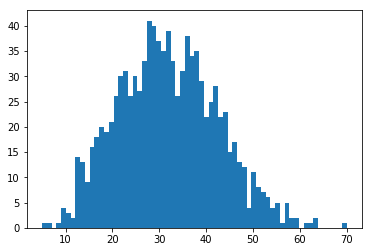

In [9]:
print("Total number of utterances:", len(utt_lengths["duration"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["duration"]["train"]))
hist(utt_lengths["duration"]["train"], bins=64);

Total number of utterances: 1000
Total number of frames: 534363


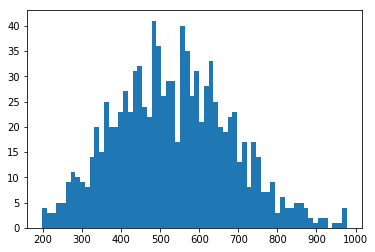

In [10]:
print("Total number of utterances:", len(utt_lengths["acoustic"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["acoustic"]["train"]))
hist(utt_lengths["acoustic"]["train"], bins=64);

### How data look like?

Pick an utterance from training data and visualize its features.

In [11]:
def vis_utterance(X, Y, lengths, idx):
    """Visualize the following features:
    
    1. Linguistic features
    2. Spectrogram
    3. F0
    4. Aperiodicity
    """
    x = X[idx][:lengths[idx]]
    y = Y[idx][:lengths[idx]]
    
    figure(figsize=(16,20))
    subplot(4,1,1)
    # haha, better than text?
    librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
    
    subplot(4,1,2)
    logsp = np.log(pysptk.mc2sp(y[:,mgc_start_idx:mgc_dim//len(windows)], alpha=alpha, fftlen=fftlen))
    librosa.display.specshow(logsp.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    
    subplot(4,1,3)
    lf0 = y[:,mgc_start_idx]
    vuv = y[:,vuv_start_idx]
    plot(lf0, linewidth=2, label="Continuous log-f0")
    plot(vuv, linewidth=2, label="Voiced/unvoiced flag")
    legend(prop={"size": 14}, loc="upper right")
    
    subplot(4,1,4)
    bap = y[:,bap_start_idx:bap_start_idx+bap_dim//len(windows)]
    bap = np.ascontiguousarray(bap).astype(np.float64)
    aperiodicity = pyworld.decode_aperiodicity(bap, fs, fftlen)
    librosa.display.specshow(aperiodicity.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    # colorbar()

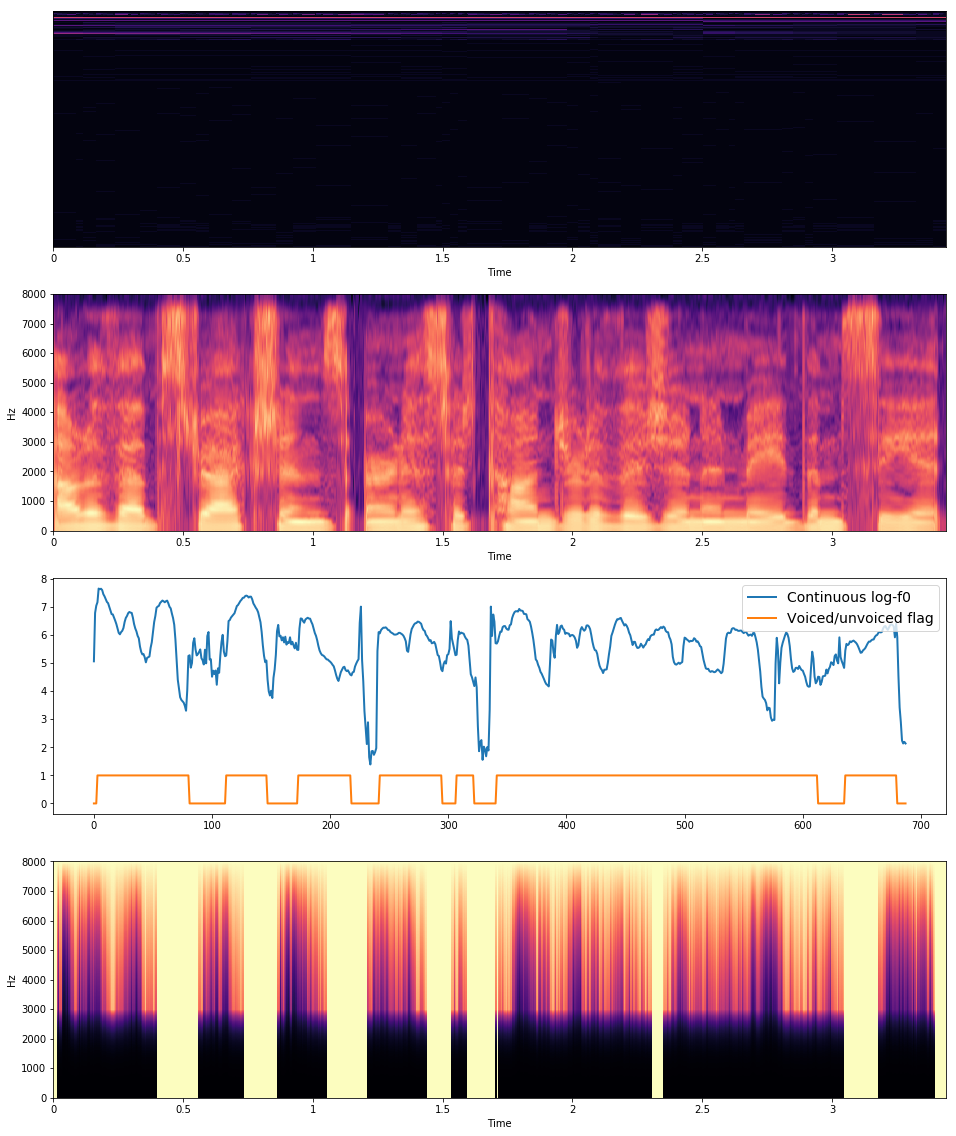

In [12]:
idx = 0
vis_utterance(X["acoustic"]["train"], Y["acoustic"]["train"], utt_lengths["acoustic"]["train"], idx)

As you can see the top of the images, linguistic features are not clear. This is because linguistic features have very differnt scale for each dimention. This will be clear after normalization.

### Statistics

Before training neural networks, we need to normalize data. Following Merlin's demo script, we will apply min/max normalization for linguistic features and mean/variance normalization to duration/acoustic features. You can compute necessary statistics using `nnmnkwii.preprocessing.minmax` and `nnmnkwii.preprocessing.meanvar`. The comptuation is online, so we can use the functionality for any large dataset.

In [13]:
X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_scale = {}

for typ in ["acoustic", "duration"]:
    X_min[typ], X_max[typ] = minmax(X[typ]["train"], utt_lengths[typ]["train"])
    Y_mean[typ], Y_var[typ] = meanvar(Y[typ]["train"], utt_lengths[typ]["train"])
    Y_scale[typ] = np.sqrt(Y_var[typ])

Linguistic features should be clear with normalization as shown below.

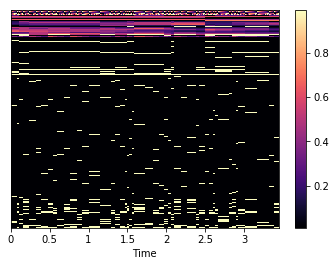

In [14]:
idx = 0
typ = "acoustic"
x = X[typ]["train"][idx][:utt_lengths[typ]["train"][idx]]
x = minmax_scale(x, X_min[typ], X_max[typ], feature_range=(0.01, 0.99))
librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
colorbar()

### Combine datasets and normalization.

In this demo we use PyTorch to build DNNs. `PyTorchDataset` is just a glue Dataset wrapper, which combines our dataset and normalization. Note that since our dataset is zero-padded, we need its lengths.

In [15]:
from torch.utils import data as data_utils
import torch

class PyTorchDataset(torch.utils.data.Dataset):
    """Thin dataset wrapper for pytorch
    
    This does just two things:
        1. On-demand normalization
        2. Returns torch.tensor instead of ndarray
    """
    def __init__(self, X, Y, lengths, X_min, X_max, Y_mean, Y_scale):
        self.X = X
        self.Y = Y
        if isinstance(lengths, list):
            lengths = np.array(lengths)[:,None]
        elif isinstance(lengths, np.ndarray):
            lengths = lengths[:,None]
        self.lengths = lengths
        self.X_min = X_min
        self.X_max = X_max
        self.Y_mean = Y_mean
        self.Y_scale = Y_scale
    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        x = minmax_scale(x, self.X_min, self.X_max, feature_range=(0.01, 0.99))
        y = scale(y, self.Y_mean, self.Y_scale)
        l = torch.from_numpy(self.lengths[idx])
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        return x, y, l
    def __len__(self):
        return len(self.X)

##  Model

We use bidirectional LSTM-based RNNs. Using PyTorch, it's very easy to implement. To handle variable length sequences in mini-batch, we can use [PackedSequence](http://pytorch.org/docs/master/nn.html#torch.nn.utils.rnn.PackedSequence).

In [16]:
import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

In [17]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes=[512, 256]):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size)
             for (in_size, out_size) in zip(in_sizes, sizes)])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, inputs):
        for linear in self.layers:
            inputs = self.dropout(self.relu(linear(inputs)))
        return inputs

In [18]:
class BatchNormConv1d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding,
                 activation=None):
        super(BatchNormConv1d, self).__init__()
        self.conv1d = nn.Conv1d(in_dim, out_dim,
                                kernel_size=kernel_size,
                                stride=stride, padding=padding, bias=False)
        # Following tensorflow's default parameters
        self.bn = nn.BatchNorm1d(out_dim, momentum=0.99, eps=1e-3)
        self.activation = activation

    def forward(self, x):
        x = self.conv1d(x)
        if self.activation is not None:
            x = self.activation(x)
        return self.bn(x)

In [19]:
class Highway(nn.Module):
    def __init__(self, in_size, out_size):
        super(Highway, self).__init__()
        self.H = nn.Linear(in_size, out_size)
        self.H.bias.data.zero_()
        self.T = nn.Linear(in_size, out_size)
        self.T.bias.data.fill_(-1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        H = self.relu(self.H(inputs))
        T = self.sigmoid(self.T(inputs))
        return H * T + inputs * (1.0 - T)

In [20]:
class CBHG(nn.Module):
    """CBHG module: a recurrent neural network composed of:
        - 1-d convolution banks
        - Highway networks + residual connections
        - Bidirectional gated recurrent units
    """

    def __init__(self, in_dim, K=16, projections=[256, 256]):
        super(CBHG, self).__init__()
        self.in_dim = in_dim
        self.relu = nn.ReLU()
        self.conv1d_banks = nn.ModuleList(
            [BatchNormConv1d(in_dim, in_dim, kernel_size=k, stride=1,
                             padding=k // 2, activation=self.relu)
             for k in range(1, K + 1)])
        self.max_pool1d = nn.MaxPool1d(kernel_size=2, stride=1, padding=1)

        in_sizes = [K * in_dim] + projections[:-1]
        activations = [self.relu] * (len(projections) - 1) + [None]
        self.conv1d_projections = nn.ModuleList(
            [BatchNormConv1d(in_size, out_size, kernel_size=3, stride=1,
                             padding=1, activation=ac)
             for (in_size, out_size, ac) in zip(
                 in_sizes, projections, activations)])

        self.pre_highway = nn.Linear(projections[-1], in_dim, bias=False)
        self.highways = nn.ModuleList(
            [Highway(in_dim, in_dim) for _ in range(4)])

        self.gru = nn.GRU(
            in_dim, in_dim, 1, batch_first=True, bidirectional=True)
        
    def forward(self, inputs, input_lengths=None):
        # (B, T_in, in_dim)
        x = inputs

        # Needed to perform conv1d on time-axis
        # (B, in_dim, T_in)
        if x.size(-1) == self.in_dim:
            x = x.transpose(1, 2)

        T = x.size(-1)

        # (B, in_dim*K, T_in)
        # Concat conv1d bank outputs
        x = torch.cat([conv1d(x)[:, :, :T] for conv1d in self.conv1d_banks], dim=1)
        assert x.size(1) == self.in_dim * len(self.conv1d_banks)
        x = self.max_pool1d(x)[:, :, :T]

        for conv1d in self.conv1d_projections:
            x = conv1d(x)

        # (B, T_in, in_dim)
        # Back to the original shape
        x = x.transpose(1, 2)

        if x.size(-1) != self.in_dim:
            x = self.pre_highway(x)

        # Residual connection
        x += inputs
        for highway in self.highways:
            x = highway(x)

        if input_lengths is not None:
            x = nn.utils.rnn.pack_padded_sequence(
                x, input_lengths, batch_first=True)

        # (B, T_in, in_dim*2)
        outputs, _ = self.gru(x)

        if input_lengths is not None:
            outputs, _ = nn.utils.rnn.pad_packed_sequence(
                outputs, batch_first=True)

        return outputs

In [21]:
# class xLSTM(nn.Module):
#     def __init__(self, input_size, xLSTM_depth, num_layers=1, bidirectional=False):
#         super(xLSTM, self).__init__()
#         self.hidden_size = xLSTM_depth
#         self.num_layers = num_layers
#         self.num_directions =  2 if bidirectional else 1
#         self.lstm = nn.LSTM(input_size, self.hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        #self.hidden2out = nn.Linear(self.num_direction*self.hidden_dim, D_out)
        
#     def init_hidden(self, batch_size):
#         h, c = (Variable(torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)), 
#                 Variable(torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)))
#         return h, c

#     def forward(self, inputs, input_lengths, h, c):
#         inputs = nn.utils.rnn.pack_padded_sequence(inputs, input_lengths, batch_first=True)
#         outputs, (h, c) = self.lstm(inputs, (h, c))
#         outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
#         #output = self.hidden2out(output)
#         return outputs

In [22]:
class MyNet(nn.Module):
    def __init__(self, in_dim, xLSTM_depth, out_dim, num_layers=1, bidirectional=False):
        super(MyNet, self).__init__()
        self.hidden_size = xLSTM_depth
        self.num_layers = num_layers
        self.num_directions =  2 if bidirectional else 1
        self.relu = nn.ReLU()       
        self.prenet = Prenet(in_dim, sizes=[512, 256])
        self.lstm = nn.LSTM(256, self.hidden_size, self.num_layers, bidirectional=bidirectional, batch_first=True)
        self.cbhg = CBHG(256, K=16, projections=[256, 256])
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, out_dim)
    
    def init_hidden(self, batch_size):
        h, c = (Variable(torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)), 
                Variable(torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)))
        return h, c
        
    def forward(self, inputs, input_lengths, h, c):
        prenet_outputs = self.prenet(inputs)    
#         prenet_outputs = nn.utils.rnn.pack_padded_sequence(prenet_outputs, input_lengths, batch_first=True)
        lstm_outputs, (h, c) = self.lstm(prenet_outputs, (h, c))
#         lstm_outputs, _ = nn.utils.rnn.pad_packed_sequence(lstm_outputs, batch_first=True)   
        cbhg_outputs = self.cbhg(lstm_outputs, input_lengths)
        fc1_outputs = self.fc1(cbhg_outputs)
        return self.fc2(self.relu(fc1_outputs))

## Train

### Configurations

Network hyper parameters and training configurations (learning rate, weight decay, etc).

In [23]:
# num_hidden_layers = 3
# hidden_size = 512

xLSTM_depth = 256

batch_size = 16
n_workers = 0
pin_memory = True
nepoch = 25
lr = 0.001
weight_decay = 1e-6
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### Trainining loop

Our RNN predicts output feature sequence given a input feature sequence, so we need to feed our data to network in sequence-wise manner. This is pretty easy. We can just use `MemoryCacheDataset` that supports utterancew-wise iteration and has cache functionality to avoid file re-loading.

In [24]:
def train(model, optimizer, X, Y, X_min, X_max, Y_mean, Y_scale,
          utt_lengths, cache_size=1000):
    if use_cuda:
        model = model.cuda()
        
    X_train, X_test = X["train"], X["test"]
    Y_train, Y_test = Y["train"], Y["test"]
    train_lengths, test_lengths = utt_lengths["train"], utt_lengths["test"]
    
    # Sequence-wise train loader
    X_train_cache_dataset = MemoryCacheDataset(X_train, cache_size)
    Y_train_cache_dataset = MemoryCacheDataset(Y_train, cache_size)
    train_dataset = PyTorchDataset(X_train_cache_dataset, Y_train_cache_dataset, train_lengths,
                                  X_min, X_max, Y_mean, Y_scale)
    train_loader = data_utils.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
    
    # Sequence-wise test loader
    X_test_cache_dataset = MemoryCacheDataset(X_test, cache_size)
    Y_test_cache_dataset = MemoryCacheDataset(Y_test, cache_size)
    test_dataset = PyTorchDataset(X_test_cache_dataset, Y_test_cache_dataset, test_lengths,
                                 X_min, X_max, Y_mean, Y_scale)
    test_loader = data_utils.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
    
    dataset_loaders = {"train": train_loader, "test": test_loader}
        
    # Training loop
    criterion = nn.MSELoss()
    model.train()
    print("Start utterance-wise training...")
    loss_history = {"train": [], "test": []}
    for epoch in tqdm(tnrange(nepoch)):
        for phase in ["train", "test"]:
            running_loss = 0
            for x, y, lengths in dataset_loaders[phase]:
                # Sort by lengths . This is needed for pytorch's PackedSequence
                sorted_lengths, indices = torch.sort(lengths.view(-1), dim=0, descending=True)
                sorted_lengths = sorted_lengths.long().numpy()
                # Get sorted batch
                x, y = x[indices], y[indices]
                # Trim outputs with max length
                y = y[:, :sorted_lengths[0]]
                
                # Init states
                h, c = model.init_hidden(len(sorted_lengths))
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                if use_cuda:
                    h, c = h.cuda(), c.cuda()
                x, y = Variable(x), Variable(y)
                optimizer.zero_grad()
                
                # Do apply model for a whole sequence at once
                # no need to keep states
                y_hat = model(x, sorted_lengths, h, c)
                loss = criterion(y_hat, y)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            loss_history[phase].append(running_loss / (len(dataset_loaders[phase])))
        
    return loss_history

### Define models

In [25]:
models = {}
for typ in ["duration", "acoustic"]:
    models[typ] = MyNet(X[typ]["train"][0].shape[-1], xLSTM_depth, Y[typ]["train"][0].shape[-1])
    print("Model for {}\n".format(typ), models[typ])

Model for duration
 MyNet(
  (relu): ReLU()
  (prenet): Prenet(
    (layers): ModuleList(
      (0): Linear(in_features=416, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
    )
    (relu): ReLU()
    (dropout): Dropout(p=0.5)
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (cbhg): CBHG(
    (relu): ReLU()
    (conv1d_banks): ModuleList(
      (0): BatchNormConv1d(
        (conv1d): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): BatchNormConv1d(
        (conv1d): Conv1d(256, 256, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (2): BatchNormConv1d(
        (conv1d): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
 

)


### Training Duration model

In [26]:
ty = "duration"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Start utterance-wise training...


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:44<00:00,  8.88s/it]

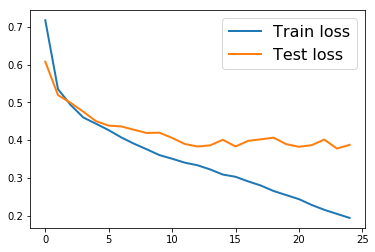

In [27]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

### Training acoustic model

In [28]:
ty = "acoustic"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Start utterance-wise training...


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory

In [ ]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})

## Test

Let's see how our network works.

### Parameter generation utilities

Almost same as DNN text-to-speech syntheiss. The difference is that we need to give initial hidden states explicitly.

In [ ]:
binary_dict, continuous_dict = hts.load_question_set(join(DATA_ROOT, "questions-radio_dnn_416.hed"))

def gen_parameters(y_predicted):
    # Number of time frames
    T = y_predicted.shape[0]
    
    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    vuv = y_predicted[:,vuv_start_idx]
    bap = y_predicted[:,bap_start_idx:]
    
    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(Y_var[ty][:lf0_start_idx], (T, 1))
    mgc = paramgen.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(Y_var[ty][lf0_start_idx:vuv_start_idx], (T,1))
    lf0 = paramgen.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(Y_var[ty][bap_start_idx:], (T, 1))
    bap = paramgen.mlpg(bap, bap_variances, windows)
    
    return mgc, lf0, vuv, bap

def gen_waveform(y_predicted, do_postfilter=False):  
    y_predicted = trim_zeros_frames(y_predicted)
        
    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted)
    
    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)
        
    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])
    
    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period).astype(int16)
    return generated_waveform
    
def gen_duration(label_path, duration_model):
    # Linguistic features for duration
    hts_labels = hts.load(label_path)
    duration_linguistic_features = fe.linguistic_features(hts_labels,
                                               binary_dict, continuous_dict,
                                               add_frame_features=False,
                                               subphone_features=None).astype(np.float32)

    # Apply normalization
    ty = "duration"
    duration_linguistic_features = minmax_scale(duration_linguistic_features, 
                                       X_min[ty], X_max[ty], feature_range=(0.01, 0.99))
    
    # Apply model
    duration_model = duration_model.cpu()
    duration_model.eval()
    x = Variable(torch.from_numpy(duration_linguistic_features)).float()
    duration_predicted = duration_model(x).data.numpy()
                     
    # Apply denormalization
    duration_predicted = duration_predicted * Y_scale[ty] + Y_mean[ty]
    duration_predicted = np.round(duration_predicted)
    
    # Set minimum state duration to 1
    duration_predicted[duration_predicted <= 0] = 1
    hts_labels.set_durations(duration_predicted)
    
    return hts_labels    


def test_one_utt(label_path, duration_model, acoustic_model, post_filter=True):
    # Predict durations
    duration_modified_hts_labels = gen_duration(label_path, duration_model)
    
    # Linguistic features
    linguistic_features = fe.linguistic_features(duration_modified_hts_labels, 
                                                  binary_dict, continuous_dict,
                                                  add_frame_features=True,
                                                  subphone_features="full")
    # Trim silences
    indices = duration_modified_hts_labels.silence_frame_indices()
    linguistic_features = np.delete(linguistic_features, indices, axis=0)

    # Apply normalization
    ty = "acoustic"
    linguistic_features = minmax_scale(linguistic_features, 
                                       X_min[ty], X_max[ty], feature_range=(0.01, 0.99))
    
    # Predict acoustic features
    acoustic_model = acoustic_model.cpu()
    acoustic_model.eval()    
    x = Variable(torch.from_numpy(linguistic_features)).float()
    acoustic_predicted = acoustic_model(x).data.numpy()
             
    # Apply denormalization
    acoustic_predicted = acoustic_predicted * Y_scale[ty] + Y_mean[ty]
    
    return gen_waveform(acoustic_predicted, post_filter)    

### Listen generated audio

Generated audio samples with Merlin's slt_full_demo are attached. You can compare them below.

In [ ]:
test_label_paths = sorted(glob(join(DATA_ROOT, "label_state_align/", "*.lab")))[::-1][:5][::-1]
merlin_generated_wav_files = sorted(glob(join("E:\\tts\\nnmnkwii_gallery\\generated\\merlin_slt_arctic_full\\*.wav")))
lstm_generated_wav_files = sorted(glob(join("E:\\tts\\nnmnkwii_gallery\\generated\\LSTM\\*.wav")))

# Save generated wav files for later comparizon
save_dir = join("E:\\tts\\nnmnkwii_gallery\\generated\\MyNet")
if not exists(save_dir):
    os.makedirs(save_dir)
    
for label_path, wav_path1, wav_path2 in zip(test_label_paths,
                                            lstm_generated_wav_files,
                                            merlin_generated_wav_files):
    print("LSTM")
    fs, waveform = wavfile.read(wav_path1)
    IPython.display.display(Audio(waveform, rate=fs))    
    
    print("MyNet")
    waveform = test_one_utt(label_path, models["duration"], models["acoustic"])
    wavfile.write(join(save_dir, basename(wav_path1)), rate=fs, data=waveform)
    IPython.display.display(Audio(waveform, rate=fs))
    
    print("Merlin (slt_arctic_full, generated with default configurations)")
    fs, waveform = wavfile.read(wav_path2)
    IPython.display.display(Audio(waveform, rate=fs))    